In [1]:
import mne
import librosa
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
from time import time

from torchinfo import summary

# from https://github.com/Po-Hsun-Su/pytorch-ssim
import pytorch_ssim as ssim

import matplotlib.pyplot as plt
import librosa.display
from ipywidgets import IntProgress
from IPython.display import display, Audio

# Music Data

In [2]:
musics = np.load('omiir_music.npy', allow_pickle=True).item()

## Preparation - Resampling, STFT, etc.

In [3]:
def prepare_downsampling(target_sr, stft=False, stft_window=256):
    for version in musics.keys():
        for mid, music in musics[version].items():
            wav = (music['wav'] - music['wav'].mean())/music['wav'].std()
            music['wav-low'] = librosa.resample(wav, orig_sr=music['rate'], target_sr=target_sr)
            music['rate-low'] = target_sr
            music['sample-low'] = music['wav-low'].shape[0]
            music['onset-low'] = np.round(music['onset']/music['rate']*music['rate-low']).astype(int)
            music['onset_woc-low'] = np.round(music['onset_woc']/music['rate']*music['rate-low']).astype(int)
            music['beat-low'] = np.round(music['beat']/music['rate']*music['rate-low']).astype(int)
            music['beat_woc-low'] = np.round(music['beat_woc']/music['rate']*music['rate-low']).astype(int)
            
            if stft:
                music['stft-low'] = librosa.stft(music['wav-low'], hop_length=stft_window, win_length=stft_window)

            music['audio'] = Audio(data=wav, rate=music['rate'])
            music['audio-low'] = Audio(data=librosa.resample(music['wav-low'], orig_sr=target_sr, target_sr=music['rate']), rate=music['rate'])

# EEG Data

In [4]:
data_eeg = mne.io.read_raw_fif('omiir_all_preprocessed.fif', preload=True)
EEG_RATE = data_eeg.info['sfreq']
data_eeg

Opening raw data file omiir_all_preprocessed.fif...
    Range : 0 ... 1287637 =      0.000 ... 20119.328 secs
Ready.


C:\Users\Paul\AppData\Local\Temp\ipykernel_137036\1980649454.py:1: RuntimeWarning: This filename (omiir_all_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data_eeg = mne.io.read_raw_fif('omiir_all_preprocessed.fif', preload=True)


Reading 0 ... 1287637  =      0.000 ... 20119.328 secs...


<Raw | omiir_all_preprocessed.fif, 70 x 1287638 (20119.3 s), ~687.8 MB, data loaded>

## Preprocess - Standardization + Trim

In [5]:
data_eeg_raw = data_eeg.get_data('eeg')

print(f"Size in memory: {data_eeg_raw.size * data_eeg_raw.itemsize / 1e6:.2f} mb")

subids_idx = data_eeg.get_data('SUBID').reshape(-1).astype(int)
subids = sorted(set(subids_idx))

z_cutoff = 2
start_idx = 0
for subid in subids:
    end_idx = np.searchsorted(subids_idx, subid, side='right')
    mean = data_eeg_raw[:, start_idx:end_idx].mean(axis=1)
    std = data_eeg_raw[:, start_idx:end_idx].std(axis=1)
    t = data_eeg_raw[:, start_idx:end_idx].transpose()
    standardized = ((t - mean)/std).transpose()
    
    data_eeg_raw[:, start_idx:end_idx] = np.clip(standardized, a_min=-z_cutoff, a_max=z_cutoff)/z_cutoff  # Clip + Scale to -1>1

Size in memory: 659.27 mb


## Events

In [6]:
def sep_event_id(eid):
    '''
        return: music-id(str), trial_type(int), version(str)
    '''
    return f'{int(str(eid)[:-2]):02d}', int(str(eid)[-2]), f'v{str(eid)[-1]}'

In [7]:
data_events = mne.find_events(data_eeg, initial_event=True)
data_events_info = np.hstack([
    data_events[:, 0].reshape(-1, 1),  # start
    np.concatenate([data_events[1:, 0], [data_eeg.last_samp - 1]]).reshape(-1, 1), # end
    np.asarray([sep_event_id(eid) for eid in data_events[:, 2]], dtype='object'),  # music-id, trial_type, version
    data_eeg.get_data('SUBID')[0, data_events[:, 0]].astype(int).reshape(-1, 1)  # subid
])

1620 events found
Event IDs: [ 111  112  121  122  131  132  211  212  221  222  231  232  311  312
  321  322  331  332  411  412  421  422  431  432 1111 1112 1121 1122
 1131 1132 1211 1212 1221 1222 1231 1232 1311 1312 1321 1322 1331 1332
 1411 1412 1421 1422 1431 1432 2111 2112 2121 2122 2131 2132 2211 2212
 2221 2222 2231 2232 2311 2312 2321 2322 2331 2332 2411 2412 2421 2422
 2431 2432]


# Dataset Selection

In [8]:
idx_EEG_START, idx_EEG_STOP, idx_MID, idx_TRIAL, idx_VERSION, idx_SUBID = 0, 1, 2, 3, 4, 5
TRIAL = dict(
    LISTEN=1,
    IMAGE=2,
    IMAGE_WOC=3,
)

In [9]:
def events_iter(batch_size, filter_trial_type=None, filter_subject_ids=None, custom_filter=None, shuffle=False):
    # Filter
    events_filter = np.ones(data_events_info.shape[0]).astype(bool)
    if filter_trial_type is not None:
        events_filter &= data_events_info[:, idx_TRIAL] == filter_trial_type
    if filter_subject_ids is not None:
        events_filter &= np.isin(data_events_info[:, idx_SUBID], filter_subject_ids)
    if custom_filter is not None:
        events_filter &= custom_filter
    
    events_idx = np.argwhere(events_filter).reshape(-1)
    
    # Shuffle
    if shuffle:
        np.random.shuffle(events_idx)
    
    # Return
    res = []
    for i in range(0, events_idx.shape[0], batch_size):
        j = min(events_idx.shape[0], i+batch_size)
        res.append(events_idx[i: j])
    return res

In [10]:
def array_iter(arr, shuffle=False, extend=None):
    indices = np.arange(arr.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    
    res = []
    for idx in indices:
        res.append(arr[idx])
    
    if extend is not None:
        length = len(indices)
        for idx in range(extend-length):
            res.append(arr[indices[idx % length]])
    
    return res

In [11]:
def padding(arr, window_length, axis=0):
    if arr.shape[axis] < window_length:
        return np.pad(arr, [(0, window_length-d) if i == axis else (0, 0) for i, d in enumerate(arr.shape)], constant_values=(0))
    return arr

In [12]:
def make_iteration(indices, window_length, testing_mode=False, shuffle=True):
    io_indices = []
    music_data = []
    for eeg_start, eeg_stop, mid, _, version, _ in data_events_info[indices]:
        music = musics[version][mid]
        music_data.append(music['wav-low'])
        music_window_length = window_length/EEG_RATE*music['rate-low']
        if not music_window_length.is_integer():
            print(f'Warning: music_window_length is not integer ({music_window_length}), will be floored to {int(music_window_length)}')
        music_window_length = int(music_window_length)

        eeg_indices = [
            np.arange(eeg_start, eeg_stop, window_length),  # EEG-start
            np.concatenate([np.arange(eeg_start + window_length, eeg_stop, window_length), [eeg_stop]]) # EEG-stop
        ]
        
        cutoff = eeg_indices[0].shape[0]  # Bug: music fraction after eeg end.
        music_indices = [
            np.arange(0, music['sample-low'], music_window_length)[:cutoff],  # Music-start
            np.concatenate([np.arange(music_window_length, music['sample-low'], music_window_length), [(music['sample-low'])]])[:cutoff]  # Music-stop
        ]
        start_stop = np.stack(eeg_indices + music_indices, axis=1)
        io_indices.append(start_stop)

    max_iter = max(map(lambda x: len(x), io_indices))
    io_list = [array_iter(io, shuffle=shuffle, extend=None if testing_mode else max_iter) for io in io_indices]
    
    return max_iter, io_list, music_data

In [13]:
def training_iter(indices, window_length, shuffle=True):
    max_iter, io_list, music_data = make_iteration(indices, window_length, shuffle=shuffle)

    batch_data = []
    for it in range(max_iter):
        batch_input = []
        batch_output = []
        for io, wav in zip(io_list, music_data):
            sample_start, sample_stop, music_start, music_stop = io[it]
            batch_input.append(padding(data_eeg_raw[:, sample_start:sample_stop], window_length=window_length, axis=1))
            batch_output.append(padding(wav[music_start: music_stop], window_length=music_window_length))
        batch_data.append((np.stack(batch_input), np.stack(batch_output)))
    return batch_data

In [14]:
def testing_iter(indices, window_length, shuffle=False):
    _, io_list, music_data = make_iteration(indices, window_length, testing_mode=True, shuffle=shuffle)
    
    batch_data = []
    for io, wav in zip(io_list, music_data):
        batch_input = []
        batch_output = []
        for sample_start, sample_stop, music_start, music_stop in io:
            batch_input.append(padding(data_eeg_raw[:, sample_start:sample_stop], window_length=window_length, axis=1))
            batch_output.append(padding(wav[music_start: music_stop], window_length=music_window_length))
        batch_data.append((np.stack(batch_input), np.stack(batch_output)))
        
    return batch_data

## Train-Test Split

```
Training Set - SUB[MID(------), (------),        ]
Testing Set -  SUB[                   NEW(------)]
           NEW-SUB[(------),            ,(------)]
```

SUBJECT v1 {1, 4, 6, 7} v2 {9, 11, 12, 13, 14}

| ID | Name                                | Meter | Length | Tempo   | Train/Test | Note |
|----|-------------------------------------|-------|--------|---------|------------|------|
|  1 | Chim Chim Cheree (lyrics)           |   3/4 |  13.3s | 212 BPM | Mixed      | 
|  2 | TakeMe Out to the Ballgame (lyrics) |   3/4 |   7.7s | 189 BPM | Mixed      | 
|  3 | Jingle Bells (lyrics)               |   4/4 |   9.7s | 200 BPM | Mixed      | Train/Test: Training Subject/Testing Only Subject (v1 == v2)
|  4 | Mary Had a Little Lamb (lyrics)     |   4/4 |  11.6s | 160 BPM |  Test Only | (v1 == v2) > Unknown Song Experiment
| 11 | Chim Chim Cheree                    |   3/4 |  13.5s | 212 BPM | Mixed      | No lyrics
| 12 | TakeMe Out to the Ballgame          |   3/4 |   7.7s | 189 BPM | Mixed      | No lyrics
| 13 | Jingle Bells                        |   4/4 |   9.0s | 200 BPM | Mixed      | Nixing - No lyrics (v1 == v2)
| 14 | Mary Had a Little Lamb              |   4/4 |  12.2s | 160 BPM |  Test Only | Piano -  No lyrics (v1 == v2) > Unknown Song Experiment
| 21 | EmperorWaltz                        |   3/4 |   8.3s | 178 BPM | Mixed      | Orchestra
| 22 | Hedwig’s Theme (Harry Potter)       |   3/4 |  16.0s | 166 BPM | Mixed      | "Celesta" > Instrument Experiment
| 23 | ImperialMarch (StarWars Theme)      |   4/4 |   9.2s | 104 BPM | Mixed      | "Trombone" > Instrument Experiment
| 24 | Eine Kleine Nachtmusik              |   4/4 |   6.9s | 140 BPM | Mixed      | "Violin" > Instrument Experiment
|    |                                mean |       |  10.4s | 176 BPM |

In [15]:
TRAIN_IDS = [
    ('02', 1),
    ('03', 1),
    ('12', 1),
    ('13', 1),
    ('21', 1),
    ('23', 1),
    ('24', 1),
    
    ('01', 4),
    ('03', 4),
    ('11', 4),
    ('13', 4),
    ('21', 4),
    ('22', 4),
    ('24', 4),
    
    ('01', 6),
    ('02', 6),
    ('11', 6),
    ('12', 6),
    ('21', 6),
    ('22', 6),
    ('23', 6),
    
    ('02', 7),
    ('03', 7),
    ('12', 7),
    ('13', 7),
    ('22', 7),
    ('23', 7),
    ('24', 7),
    
]

In [16]:
VALID_IDS = [
    ('01', 1),
    ('11', 1),
    ('22', 1),
    
    ('02', 4),
    ('12', 4),
    ('23', 4),
    
    ('03', 6),
    ('13', 6),
    ('24', 6), 
    
    ('01', 7),
    ('11', 7),
    ('21', 7),
]

In [17]:
TEST_NEW_SUB = [
    # New Subject (SUBID=9)
    ('01', 9),
    ('02', 9),
    ('03', 9),
    ('11', 9),
    ('12', 9),
    ('13', 9),
    ('21', 9),
    ('22', 9),
    ('23', 9),
    
    # New Subject (SUBID=11)
    ('01', 11),
    ('02', 11),
    ('03', 11),
    ('11', 11),
    ('12', 11),
    ('13', 11),
    ('21', 11),
    ('22', 11),
    ('23', 11),
]

TEST_NEW_MUSIC = [
    # New Music '04' '14'
    ('04', 1),
    ('04', 4),
    ('04', 6),
    ('04', 9),
    ('04', 11),
    
    ('14', 1),
    ('14', 4),
    ('14', 6),
    ('14', 9),
    ('14', 11),
]

TEST_INSTRUMENT_CELESTA = [
    # Celesta
    ('22', 9),
    ('22', 11),
]
TEST_INSTRUMENT_TROMBONE = [
    # Trombone
    ('23', 9),
    ('23', 11),
]
TEST_INSTRUMENT_VIOLIN = [
    # Violin
    ('24', 9),
    ('24', 11),
]

In [18]:
train_custom_filter = list(map(lambda x: tuple(x) in TRAIN_IDS, data_events_info[:, [idx_MID, idx_SUBID]]))
valid_custom_filter = list(map(lambda x: tuple(x) in VALID_IDS, data_events_info[:, [idx_MID, idx_SUBID]]))

experiments_list = [TEST_NEW_SUB, TEST_NEW_MUSIC, TEST_INSTRUMENT_CELESTA, TEST_INSTRUMENT_TROMBONE, TEST_INSTRUMENT_VIOLIN]
ID_TEST_NEW_SUB    = 0
ID_TEST_NEW_MUSIC  = 1
ID_TEST_INSTRUMENT_CELESTA  = 2
ID_TEST_INSTRUMENT_TROMBONE = 3
ID_TEST_INSTRUMENT_VIOLIN   = 4

test_filter_list = [list(map(lambda x: tuple(x) in exp, data_events_info[:, [idx_MID, idx_SUBID]])) for exp in experiments_list]
# These filter will be merged with filter_trial_type

## Debug

In [19]:
# batch_size = 16
# window_length = 32
# trial_type = TRIAL['LISTEN']
# sub_ids = [1]
# seed = 42
# np.random.seed(seed)

# from collections import Counter
# Counter(data_events_info[(data_events_info[:, idx_TRIAL] == 1) & np.isin(data_events_info[:, idx_SUBID], [1])][:, idx_MID])

In [20]:
# total_time = 0
# last = time()
# progress = IntProgress(min=0, max=296, style={'description_width': '250px'})
# progress.description = '0/296'
# display(progress)

# epoch = 0
# for indices in events_iter(batch_size=batch_size, filter_trial_type=trial_type, filter_subject_ids=sub_ids, shuffle=True):
#     for batch_input, batch_output in training_iter(indices, window_length=window_length):
#         now = time()
#         epoch += 1
#         total_time += now - last
#         last = now
#         progress.value = epoch
#         if epoch % 10 == 0:
#             progress.description = f'total: {total_time:.2f}, avg: {total_time/epoch*1000:.2f} ms, {epoch}/296'
# progress.description = f'total: {total_time:.2f} secs, avg: {total_time/epoch*1000:.2f} ms, Done'

# Model

## MLP (WAV)

In [21]:
# class MLPModel(nn.Module):
#     def __init__(self, input_size, output_size):
#         super().__init__()
        
#         self.linears = nn.Sequential(
#             nn.Linear(input_size, 2 ** 10),
#             nn.Tanh(),
#             nn.BatchNorm1d(2 ** 10),
#             nn.Linear(2 ** 10, 2 ** 9),
#             nn.Tanh(),
#             nn.BatchNorm1d(2 ** 9),
#             nn.Linear(2 ** 9, 2 ** 8),
#             nn.Tanh(),
#             nn.BatchNorm1d(2 ** 8),
#             nn.Linear(2 ** 8, output_size),
#             nn.Tanh(),
#         )
        
#     def forward(self, X):
#         return self.linears(X)
    
#     @staticmethod
#     def transform_input(X):
#         # batch_input = (batch_size, number_channel, window_length)
#         # target (batch, input)
#         return X.reshape(X.shape[0], -1)

## BiLSTM (WAV)

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, feature_size, num_layer, hidden_size, output_size):
        super().__init__()
        
        self.linears = nn.Sequential(
            nn.Linear(input_size, feature_size),
            nn.Tanh(),
        )
        
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=num_layer,
            bidirectional=True,
            batch_first=True
        )
        self.tanh = nn.Tanh()
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, output_size),
        )
    
    def forward(self, X, state=None):
        out_1 = self.linears(X)
        state = None
        out_2 = []
        for inp in out_1:
            out, (hn, cn) = self.lstm(inp, state)
            out_2.append(out)
        out_2 = self.tanh(th.stack(out_2))
        
        out_3 = self.mlp(out_2).flatten(start_dim=1)
        
        return out_3, (hn, cn)
    
    @staticmethod
    def transform_input(X):
        # batch_input = (batch_size, number_channel, window_length)
        # target (batch, length, input)
        return X.transpose(0, 2, 1)

# Configure

In [34]:
# Music Data
music_rate = 64
enable_stft = False
stft_window = None

# Data
trial_type = 'LISTEN' # 'IMAGE' 'IMAGE_WOC'
filter_trial_type = TRIAL[trial_type]
sub_ids = None

# Model
batch_size = 16
number_channel = 64
window_length = 32
feature_size = 256
hidden_size = 256
num_layer = 4

# Train/Test
num_iteration = 1

# State
seed = 42
np.random.seed(seed)



# DO NOT CHANGE
prepare_downsampling(target_sr=music_rate, stft=enable_stft, stft_window=stft_window)
music_window_length = window_length/EEG_RATE*music_rate
if not music_window_length.is_integer():
    raise Exception('Configure Error: music_window_length must be integer')
music_window_length = int(music_window_length)

output_size = 1

# Initialize

In [24]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [25]:
net = LSTMModel(
    input_size=number_channel,
    feature_size=feature_size,
    num_layer=num_layer,
    hidden_size=hidden_size,
    output_size=output_size,
).to(device)
net_has_state = True
MODEL = 'LSTM'
MODEL_SIGNATURE = f'{256}-{256}-{4}'

In [26]:
summary(net, (1, window_length, number_channel))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 32]                   --
├─Sequential: 1-1                        [1, 32, 256]              --
│    └─Linear: 2-1                       [1, 32, 256]              16,640
│    └─Tanh: 2-2                         [1, 32, 256]              --
├─LSTM: 1-2                              [32, 512]                 5,783,552
├─Tanh: 1-3                              [1, 32, 512]              --
├─Sequential: 1-4                        [1, 32, 1]                --
│    └─Linear: 2-3                       [1, 32, 256]              131,328
│    └─Tanh: 2-4                         [1, 32, 256]              --
│    └─Linear: 2-5                       [1, 32, 128]              32,896
│    └─Tanh: 2-6                         [1, 32, 128]              --
│    └─Linear: 2-7                       [1, 32, 1]                129
Total params: 5,964,545
Trainable params: 5,964,545
Non-trainabl

In [27]:
# net = MLPModel(
#     input_size=number_channel * window_length,
#     output_size=music_window_length,
# ).to(device)
# net_has_state = False
# MODEL = 'MLP'
# MODEL_SIGNATURE = f'{2**10}-{2**8}'

In [28]:
# summary(net, (1, window_length * number_channel))

In [29]:
criterion = nn.L1Loss()  # Must edit a stats_dict if change.
optimizer = th.optim.Adam(net.parameters(), lr=0.001)

In [30]:
ssim_criterion = ssim.SSIM(size_average=False)

# Training Model

## Stats

In [31]:
stats = []
stats_dict = dict(
    iteration=0,
    trial_type=trial_type,
    loss_mode='MAE',
    
    train_loss=0.0,
    train_loss_raw=[],
    train_epoch=0,
    train_batch=0,
    
    valid_loss_raw=[],
    valid_loss_data=[],
    valid_loss=0.0,  # Equal micro
    valid_loss_micro=0.0,
    valid_loss_macro=0.0,
    valid_epoch=0,
    valid_batch=0,
    valid_difference=[],
    valid_similarity=[],
    
    best_loss=0.0,
    best_iteration=None,
    
    best_sim=0.0,
    best_sim_iteration=None,
    
    test_epoch=0,
    test_batch=0,
    
    test_loss_data=dict(),
    test_loss_raw=dict(),
    test_loss_micro=[],
    test_loss_macro=[],
    test_difference_raw=dict(),
    test_difference=[],
    test_similarity_raw=dict(),
    test_similarity=[],
)

In [32]:
def compute_difference(ref_rec, input_rec, weightage=[0.33,0.33,0.33]):
    ## Time domain similarity
    ref_time = np.correlate(ref_rec,ref_rec)
    inp_time = np.correlate(ref_rec,input_rec)
    diff_time = abs(ref_time-inp_time)
    
    ## Freq domain similarity
    ref_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(ref_rec)) 
    inp_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(input_rec))
    diff_freq = abs(ref_freq-inp_freq)
    
    ## Power similarity
    ref_power = np.sum(ref_rec**2)
    inp_power = np.sum(input_rec**2)
    diff_power = abs(ref_power-inp_power)
    
    return diff_time[0], diff_freq[0], diff_power, weightage[0] * diff_time[0] + weightage[1] * diff_freq[0] + weightage[2] * diff_power

In [33]:
def stft_tensor(wav, n_fft=64):
    stft = th.abs(th.stft(th.Tensor(wav), n_fft=n_fft, return_complex=True))
    return stft.view((1, 1) + tuple(stft.size()))

## Train/Valid

In [38]:
interation_progress = IntProgress(min=0, max=num_iteration)
interation_progress.value = 0
interation_progress.description = f'Iter: 0/{num_iteration}'
display(interation_progress)

train_progress = IntProgress(min=0, max=500)
train_progress.value = 0
max_train_epoch = '???'
train_progress.description = f'Train 0/{max_train_epoch}'
display(train_progress)

valid_progress = IntProgress(min=0, max=100)
valid_progress.value = 0
max_valid_epoch = '???'
valid_progress.description = f'Validate 0/{max_valid_epoch}'
display(valid_progress)

test_progress = IntProgress(min=0, max=100)
test_progress.value = 0
max_test_epoch = '???'
test_progress.description = f'Test 0/{max_test_epoch}'
display(test_progress)

best_loss = None
best_iter = 0

best_sim = None
best_sim_iter = 0

for iteration in range(1, num_iteration + 1):
    interation_progress.value = iteration
    interation_progress.description = f'Iter: {iteration}/{num_iteration}'
    
    monitor_loss = 0
    n_monitor = 50
    
    train_loss = []
    train_epoch = 0
    train_batch = 0
#     net.train()
#     for indices in events_iter(
#             batch_size=batch_size, filter_trial_type=filter_trial_type, filter_subject_ids=sub_ids,
#             custom_filter=train_custom_filter,
#             shuffle=True
#     ):
#         for batch_input, batch_output in training_iter(indices, window_length=window_length, shuffle=True):
#             train_epoch += 1
#             train_batch += batch_input.shape[0]
#             train_progress.value = train_epoch
#             train_progress.description = f'Train {train_epoch}/{max_train_epoch}'
            
#             # batch_input = (batch_size, number_channel, window_length)
#             X = th.Tensor(net.transform_input(batch_input)).to(device)
#             Y = th.Tensor(batch_output).to(device)

#             output = net(X)
#             if net_has_state:
#                 output, state = output
#             loss = criterion(output, Y)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             train_loss.append(loss.item())
#             monitor_loss += loss.item()
            
#             if train_epoch % n_monitor == 0:
#                 print(f'Iter: {iteration}, Epoch: {train_epoch}/{max_train_epoch}, MAELoss: {monitor_loss/n_monitor*1e6:.3f} / 1e6')
#                 monitor_loss = 0
    
#     train_progress.max = max_train_epoch = train_epoch
#     train_progress.description = f'Training Done'
#     print(f'Iter: {iteration}, Validating ...')

    valid_loss = []
    valid_loss_data = []
    valid_difference = []
    valid_similarity = []
    valid_epoch = 0
    valid_batch = 0
    net.eval()
    for indices in events_iter(
            batch_size=1, filter_trial_type=filter_trial_type, filter_subject_ids=sub_ids,
            custom_filter=valid_custom_filter,
            shuffle=False,
    ):
        valid_loss_data.append(data_events_info[indices][:, [idx_MID, idx_VERSION, idx_SUBID]])
        for batch_input, batch_output in testing_iter(indices, window_length=window_length, shuffle=False):
            valid_epoch += 1
            valid_batch += batch_input.shape[0]
            valid_progress.value = valid_epoch
            valid_progress.description = f'Validate {valid_epoch}/{max_valid_epoch}'
            
            # batch_input = (batch_size, number_channel, window_length)
            X = th.Tensor(net.transform_input(batch_input)).to(device)
            Y = th.Tensor(batch_output).to(device)
            
            with th.no_grad():
                output = net(X)
                if net_has_state:
                    output, state = output
                loss = criterion(output, Y)
            
            valid_loss.append(loss.item())
            
            wy = batch_output.flatten()
            wx = output.flatten().cpu().numpy()
            valid_difference.append(compute_difference(wy, wx))
            valid_similarity.append(ssim_criterion(stft_tensor(wx), stft_tensor(wy)).item())
    
    similarity = np.mean(np.abs(valid_similarity))
    difference = np.mean(valid_difference, axis=0)
    valid_progress.max = max_valid_epoch = valid_epoch
    valid_progress.description = f'Validate Done'
    
    temp_stats = stats_dict.copy()
    temp_stats['iteration'] = iteration
    
    temp_stats['train_epoch'] = train_epoch
    temp_stats['train_batch'] = train_batch
    
    temp_stats['train_loss'] = np.sum(train_loss)/train_batch  # batch
    temp_stats['train_loss_raw'] = np.asarray(train_loss)
    temp_stats['train_loss_epoch'] = np.mean(train_loss)
    temp_stats['train_loss_batch'] = np.sum(train_loss)/train_batch
    
    temp_stats['valid_epoch'] = valid_epoch
    temp_stats['valid_batch'] = valid_batch
    
    temp_stats['valid_loss_raw'] = np.asarray(valid_loss)
    temp_stats['valid_loss'] = np.sum(valid_loss)/valid_batch  # batch (*best model)
    temp_stats['valid_loss_micro'] = np.sum(valid_loss)/valid_batch  # by batch
    temp_stats['valid_loss_macro'] = np.mean(valid_loss)  # by number of songs
    temp_stats['valid_loss_data'] = np.concatenate(valid_loss_data)
    
    temp_stats['valid_similarity_raw'] = np.asarray(valid_similarity)
    temp_stats['valid_similarity'] = np.mean(np.abs(valid_similarity))  # (*best similar model)
    temp_stats['valid_difference_raw'] = np.asarray(valid_difference)
    temp_stats['valid_difference'] = difference[3]
    
    print(f'''====================================================================================================
Iter: {iteration},\tTraining-MAELoss: {temp_stats['train_loss_epoch']*1e6:.3f} / 1e6 (epoch), {temp_stats['train_loss_batch']*1e6:.3f} / 1e6 (batch)
\t\t Validating-MAELoss: {temp_stats['valid_loss_macro']*1e6:.3f} / 1e6 (song),  {temp_stats['valid_loss_micro']*1e6:.3f} / 1e6 (batch)
\t\tSimilarity: {similarity:.3f} Difference: {difference[3]:.2f} (Time: {difference[0]:.2f}, Frequency: {difference[1]:.2f}, Power: {difference[2]:.2f})
====================================================================================================''')
        
#     if iteration % 20 == 0:
#         th.save(net.state_dict(), f'experiments/{trial_type}_{MODEL}/model-{MODEL_SIGNATURE}-iter-{iteration:03d}.pt')
    
#     if best_loss is None or temp_stats['valid_loss'] < best_loss:
#         best_iter = iteration
#         best_loss = temp_stats['valid_loss']
#         th.save(net.state_dict(), f'experiments/{trial_type}_{MODEL}/model-{MODEL_SIGNATURE}-best-loss-iter-{best_iter:03d}.pt')
    
#     if best_sim is None or similarity > best_sim:
#         best_sim_iter = iteration
#         best_sim = similarity
#         th.save(net.state_dict(), f'experiments/{trial_type}_{MODEL}/model-{MODEL_SIGNATURE}-best-sim-iter-{best_sim_iter:03d}.pt')
        
    
    temp_stats['best_loss'] = best_loss
    temp_stats['best_iteration'] = best_iter
    
    temp_stats['best_sim'] = best_sim
    temp_stats['best_sim_iteration'] = best_sim_iter
    
    
    test_epoch = 0
    test_batch = 0
    test_loss_data = dict()
    test_loss = dict()
    test_difference = dict()
    test_similarity = dict()
    
    for test_id, experiment_filter in enumerate(test_filter_list):
        test_loss_data[test_id] = []
        test_loss[test_id] = []
        test_difference[test_id] = []
        test_similarity[test_id] = []
        
        for indices in events_iter(
            batch_size=1, filter_trial_type=filter_trial_type, filter_subject_ids=sub_ids,
            custom_filter=experiment_filter,
            shuffle=False,
        ):
            test_loss_data[test_id].append(data_events_info[indices][:, [idx_MID, idx_VERSION, idx_SUBID]])
            for batch_input, batch_output in testing_iter(indices, window_length=window_length, shuffle=False):
                test_epoch += 1
                test_batch += batch_input.shape[0]
                test_progress.value = test_epoch
                test_progress.description = f'Test {test_epoch}/{max_test_epoch}'

                # batch_input = (batch_size, number_channel, window_length)
                X = th.Tensor(net.transform_input(batch_input)).to(device)
                Y = th.Tensor(batch_output).to(device)

                with th.no_grad():
                    output = net(X)
                    if net_has_state:
                        output, state = output
                    loss = criterion(output, Y)

                test_loss[test_id].append(loss.item())

                wy = batch_output.flatten()
                wx = output.flatten().cpu().numpy()
                test_difference[test_id].append(compute_difference(wy, wx))
                test_similarity[test_id].append(ssim_criterion(stft_tensor(wx), stft_tensor(wy)).item())
    
    test_progress.max = max_test_epoch = test_epoch
    test_progress.description = f'Test Done'
    
    temp_stats['test_epoch'] = test_epoch
    temp_stats['test_batch'] = test_batch
    
    temp_stats['test_loss_data'] = test_loss_data
    temp_stats['test_loss_raw'] = test_loss
    temp_stats['test_difference_raw'] = test_difference
    temp_stats['test_similarity_raw'] = test_similarity
    
    temp_stats['test_loss_micro'] = []
    temp_stats['test_loss_macro'] = []
    temp_stats['test_difference'] = []
    temp_stats['test_similarity'] = []
    for test_id in range(len(experiments_list)):
        temp_stats['test_loss_micro'].append(np.sum(test_loss[test_id])/test_batch)
        temp_stats['test_loss_macro'].append(np.mean(test_loss[test_id]))
        temp_stats['test_difference'].append(np.mean(test_difference[test_id], axis=0)[3])
        temp_stats['test_similarity'].append(np.mean(np.abs(test_similarity[test_id])))
    
    stats.append(temp_stats)

IntProgress(value=0, description='Iter: 0/1', max=1)

IntProgress(value=0, description='Train 0/???', max=500)

IntProgress(value=0, description='Validate 0/???')

IntProgress(value=0, description='Test 0/???')

C:\Users\Paul\AppData\Local\Temp\ipykernel_137036\3702285087.py:123: RuntimeWarning: invalid value encountered in scalar divide
  temp_stats['train_loss'] = np.sum(train_loss)/train_batch  # batch
D:\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Paul\AppData\Local\Temp\ipykernel_137036\3702285087.py:126: RuntimeWarning: invalid value encountered in scalar divide
  temp_stats['train_loss_batch'] = np.sum(train_loss)/train_batch


Iter: 1,	Training-MAELoss: nan / 1e6 (epoch), nan / 1e6 (batch)
		 Validating-MAELoss: 20897.209 / 1e6 (song),  798.619 / 1e6 (batch)
		Similarity: 0.063 Difference: 1047.84 (Time: 2.76, Frequency: 3169.74, Power: 2.76)


In [ ]:
ID_TEST_NEW_SUB    = 0
ID_TEST_NEW_MUSIC  = 1
ID_TEST_INSTRUMENT_CELESTA  = 2
ID_TEST_INSTRUMENT_TROMBONE = 3
ID_TEST_INSTRUMENT_VIOLIN   = 4

In [48]:
temp_stats['valid_similarity']

0.0633551608538255

In [47]:
(temp_stats['test_similarity'][0] * 18 + temp_stats['test_similarity'][1] * 10 + np.mean(temp_stats['test_similarity'][-3:]) * 6)/(10 + 18 + 6)

0.08440357201787478

In [ ]:
temp_stats['test_similarity'][1] * 10

In [43]:
np.mean(temp_stats['test_similarity'][-3:])

0.05586968320421875

## Save Stats

In [34]:
np.save(f'experiments/{trial_type}_{MODEL}/stats.npy', stats)

# Results

# Load Stats to Dataframe

In [36]:
stats = list(np.load(f'experiments/{trial_type}_{MODEL}/stats.npy', allow_pickle=True))
stats_df = pd.DataFrame(list(stats))
stats_df

,iteration,trial_type,loss_mode,train_loss,train_loss_raw,train_epoch,train_batch,valid_loss_raw,valid_loss_data,valid_loss,...,test_loss_micro,test_loss_macro,test_difference_raw,test_difference,test_similarity_raw,test_similarity,train_loss_epoch,train_loss_batch,valid_similarity_raw,valid_difference_raw
0,1,LISTEN,MAE,0.001577,"[0.051779426634311676, 0.12697598338127136, 0....",328,5100,"[0.010601341724395752, 0.011084054596722126, 0...","[[11, v1, 1], [01, v1, 1], [22, v1, 1], [22, v...",0.000805,...,"[0.0004948245847704213, 7.699649246507992e-05,...","[0.025483466115676694, 0.007137574851512909, 0...","{0: [(0.3398941350042543, 217.53224640272293, ...","[1405.2204061781933, 36.86024867858133, 11917....",{0: [(0.13783517479896545-0.08335605263710022j...,"[0.09658131851825072, 0.32846911339637236, 0.0...",0.024525,0.001577,"[(0.05841917544603348-0.014153152704238892j), ...","[[0.22734036894565013, 232.79653780034567, 0.2..."
1,2,LISTEN,MAE,0.001559,"[0.010882338508963585, 0.010339673608541489, 0...",323,5020,"[0.010399121791124344, 0.010830387473106384, 0...","[[11, v1, 1], [01, v1, 1], [22, v1, 1], [22, v...",0.000796,...,"[0.0004903037768126563, 7.267593794945375e-05,...","[0.025250644505851797, 0.006737059447914362, 0...","{0: [(0.33988030402746633, 217.5233945775786, ...","[1405.1889170024222, 36.847302562196596, 11917...",{0: [(0.11225182563066483-0.0776500552892685j)...,"[0.09235063627379238, 0.3592118322507249, 0.00...",0.024232,0.001559,"[(0.05772246792912483-0.008300064131617546j), ...","[[0.2266431618927191, 232.0825977781443, 0.225..."
2,3,LISTEN,MAE,0.001536,"[0.021854277700185776, 0.015845561400055885, 0...",328,5100,"[0.010465110652148724, 0.010878678411245346, 0...","[[11, v1, 1], [01, v1, 1], [22, v1, 1], [22, v...",0.000800,...,"[0.0004922619863074703, 7.509671718267947e-05,...","[0.02535149229483472, 0.006961465682834387, 0....","{0: [(0.3398217036798983, 217.48589035513507, ...","[1405.2123780986597, 36.8493724650848, 11917.9...",{0: [(0.1425408124923706-0.09659639000892639j)...,"[0.09837518001941707, 0.3278994420128808, 0.00...",0.023888,0.001536,"[(0.06132879853248596-0.022768564522266388j), ...","[[0.22722301841503273, 232.67637085699346, 0.2..."
3,4,LISTEN,MAE,0.001539,"[0.01801033318042755, 0.020898442715406418, 0....",333,5180,"[0.010887788608670235, 0.011286613531410694, 0...","[[11, v1, 1], [01, v1, 1], [22, v1, 1], [22, v...",0.000813,...,"[0.0004984523783545407, 8.086151651387076e-05,...","[0.025670297485258845, 0.007495862580835819, 0...","{0: [(0.33984683027289697, 217.50197137465423,...","[1405.2436906660885, 36.878288363178605, 11918...",{0: [(0.1413465142250061-0.08092253655195236j)...,"[0.09495186840939872, 0.31982764360455446, 0.0...",0.023946,0.001539,"[(0.046397995203733444-0.014602163806557655j),...","[[0.22713057359994326, 232.58170736634185, 0.2..."
4,5,LISTEN,MAE,0.001524,"[0.016065077856183052, 0.010492324829101562, 0...",333,5180,"[0.01047163549810648, 0.01093268021941185, 0.1...","[[11, v1, 1], [01, v1, 1], [22, v1, 1], [22, v...",0.000799,...,"[0.0004918745452660701, 7.417719166207468e-05,...","[0.025331539081202614, 0.0068762256670743226, ...","{0: [(0.339858150293799, 217.50921618803156, 0...","[1405.228316911596, 36.86448482203246, 11917.9...",{0: [(0.12754686176776886-0.07813835144042969j...,"[0.09729018148883603, 0.34321087330256544, 0.0...",0.023709,0.001524,"[(0.062212906777858734-0.012491871602833271j),...","[[0.22713334147987993, 232.584541675397, 0.222..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,116,LISTEN,MAE,0.001389,"[0.02284892275929451, 0.023917049169540405, 0....",328,5100,"[0.010820749215781689, 0.011444205418229103, 0...","[[11, v1, 1], [01, v1, 1], [22, v1, 1], [22, v...",0.000799,...,"[0.0004904139668408464, 7.531428860325644e-05,...","[0.02525631929230359, 0.006981634553521871, 0....","{0: [(0.3402542071998996, 217.76269260793592, ...","[1405.1820832636147, 36.895086209908534, 11918...",{0: [(0.121238984167

## Training - Validating Plots

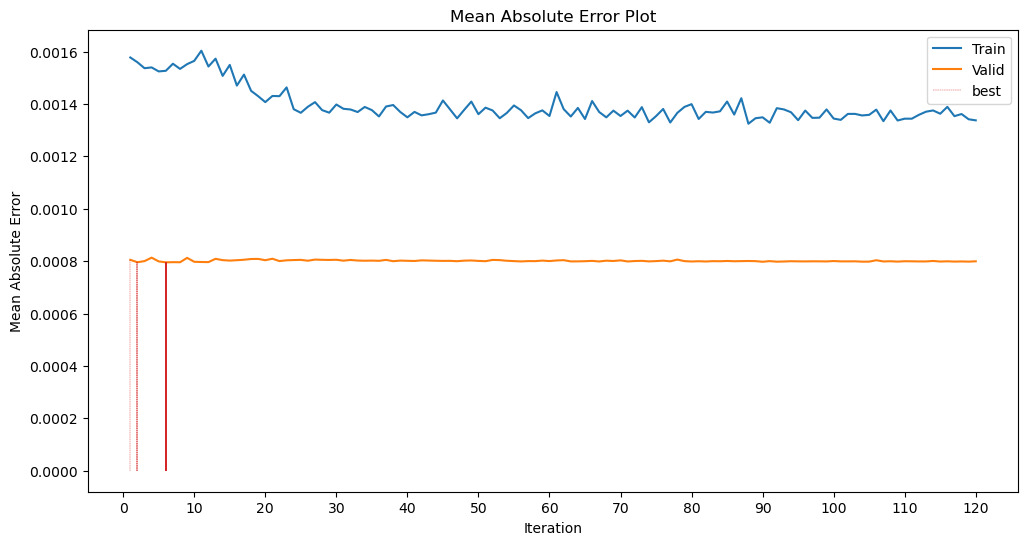

In [37]:
fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()
ax.set_title('Mean Absolute Error Plot')
line_train = ax.plot(range(1, num_iteration + 1), stats_df['train_loss'], color='tab:blue')
line_valid = ax.plot(range(1, num_iteration + 1), stats_df['valid_loss'], color='tab:orange')
line_best = ax.vlines(stats_df['best_iteration'], ymin=0, ymax=stats_df['best_loss'], colors='tab:red', linewidth=0.3, linestyles='--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Mean Absolute Error')
ax.set_xticks(range(0, num_iteration + 1, 10))

# ax2 = ax.twinx()
# line_valid_macro = ax2.plot(range(1, num_iteration + 1), stats_df['valid_loss_macro'], color='tab:green', alpha=.7)

ax.legend(line_train + line_valid + [line_best], ['Train', 'Valid', 'best'])

# ax.set_ylim(stats_df['train_loss'].min() * .2, stats_df['train_loss'].max() * .6)
plt.show()

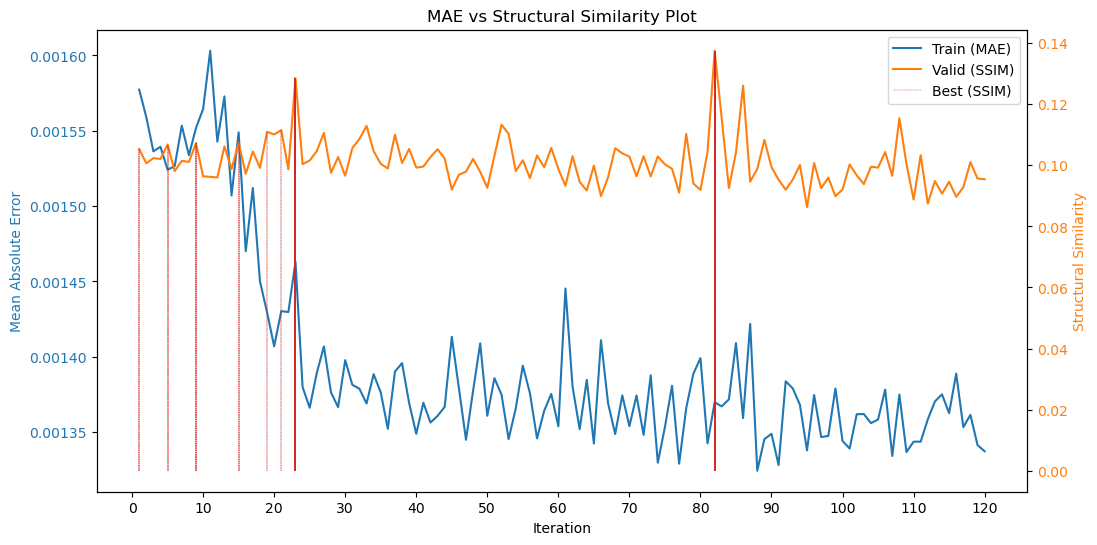

In [38]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.subplots()
ax1.set_title('MAE vs Structural Similarity Plot')
line_train = ax1.plot(range(1, num_iteration + 1), stats_df['train_loss_raw'].apply(lambda x: np.sum(x))/stats_df['train_batch'], color='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
line_valid = ax2.plot(range(1, num_iteration + 1), stats_df['valid_similarity'], color='tab:orange')
line_best = ax2.vlines(stats_df['best_sim_iteration'], ymin=0, ymax=stats_df['best_sim'], colors='tab:red', linewidth=0.3, linestyles='--')

ax1.legend(line_train + line_valid + [line_best], ['Train (MAE)', 'Valid (SSIM)', 'Best (SSIM)'])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Mean Absolute Error', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('Structural Similarity', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
# line_best = ax.vlines(stats_df['best_sim'], ymin=0, ymax=stats_df['best_sim'], colors='tab:green', linewidth=0.3, linestyles='--')

ax1.set_xticks(range(0, num_iteration + 1, 10))
plt.show()

## Testing Plots

### Known / Unknown / New Subjects

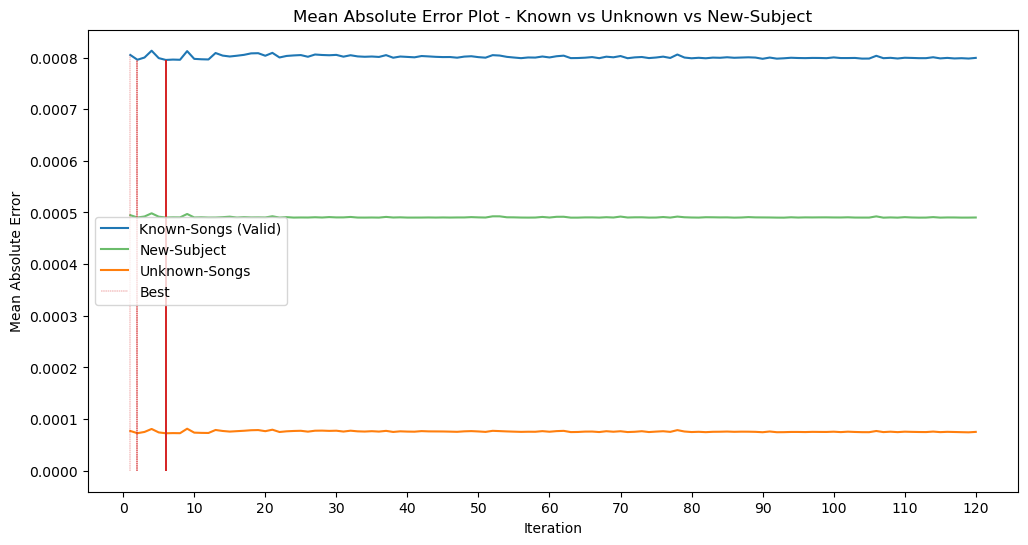

In [39]:
stat_to_plot = np.stack(stats_df['test_loss_micro'].to_numpy())

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()
ax.set_title('Mean Absolute Error Plot - Known vs Unknown vs New-Subject')
line_known = ax.plot(range(1, num_iteration + 1), stats_df['valid_loss'], color='tab:blue')
line_unknown = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_NEW_MUSIC], color='tab:orange')
line_newsub = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_NEW_SUB], color='tab:green', alpha=.7)
line_best = ax.vlines(stats_df['best_iteration'], ymin=0, ymax=stats_df['best_loss'], colors='tab:red', linewidth=0.3, linestyles='--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Mean Absolute Error')
ax.set_xticks(range(0, num_iteration + 1, 10))

ax.legend(line_known + line_newsub + line_unknown + [line_best], ['Known-Songs (Valid)', 'New-Subject', 'Unknown-Songs', 'Best'])
plt.show()

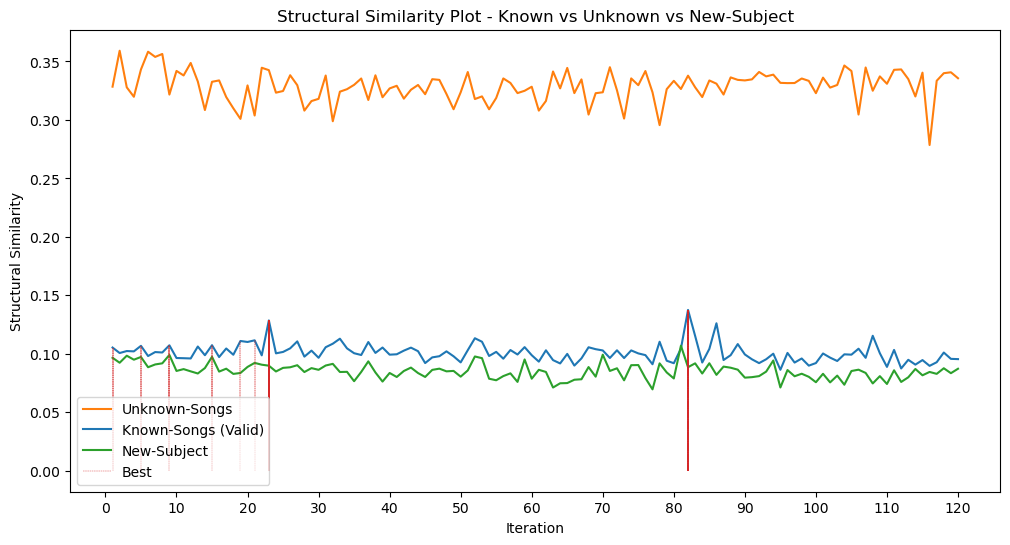

In [40]:
stat_to_plot = np.stack(stats_df['test_similarity'].to_numpy())

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()
ax.set_title('Structural Similarity Plot - Known vs Unknown vs New-Subject')
line_known = ax.plot(range(1, num_iteration + 1), stats_df['valid_similarity'], color='tab:blue')
line_unknown = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_NEW_MUSIC], color='tab:orange')
line_newsub = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_NEW_SUB], color='tab:green')
line_best = ax.vlines(stats_df['best_sim_iteration'], ymin=0, ymax=stats_df['best_sim'], colors='tab:red', linewidth=0.3, linestyles='--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Structural Similarity')
ax.set_xticks(range(0, num_iteration + 1, 10))

ax.legend(line_unknown + line_known + line_newsub + [line_best], ['Unknown-Songs', 'Known-Songs (Valid)', 'New-Subject', 'Best'])
plt.show()

### By Instruments

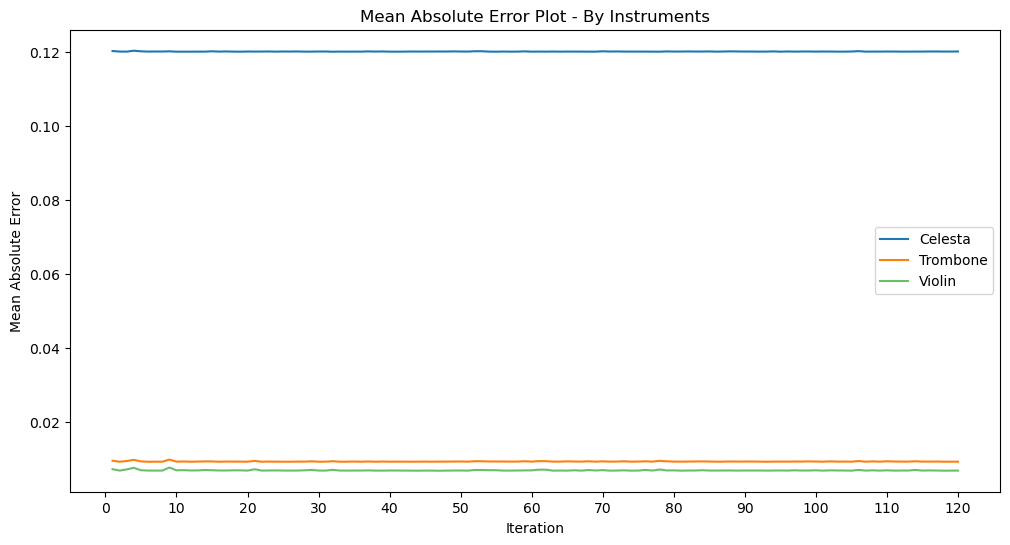

In [43]:
stat_to_plot = np.stack(stats_df['test_loss_macro'].to_numpy())

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()
ax.set_title('Mean Absolute Error Plot - By Instruments')
line_celesta = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_INSTRUMENT_CELESTA], color='tab:blue')
line_trombone = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_INSTRUMENT_TROMBONE], color='tab:orange')
line_violin = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_INSTRUMENT_VIOLIN], color='tab:green', alpha=.7)
# line_best = ax.vlines(stats_df['best_iteration'], ymin=0, ymax=stats_df['best_loss'], colors='tab:red', linewidth=0.3, linestyles='--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Mean Absolute Error')
ax.set_xticks(range(0, num_iteration + 1, 10))

ax.legend(line_celesta + line_trombone + line_violin, ['Celesta', 'Trombone', 'Violin'])
plt.show()

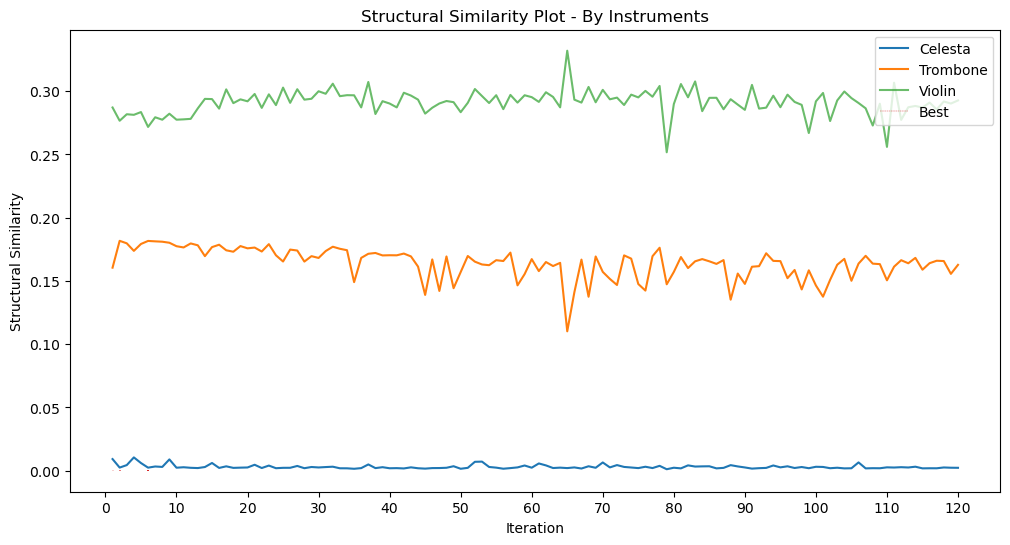

In [44]:
stat_to_plot = np.stack(stats_df['test_similarity'].to_numpy())

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()
ax.set_title('Structural Similarity Plot - By Instruments')
line_celesta = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_INSTRUMENT_CELESTA], color='tab:blue')
line_trombone = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_INSTRUMENT_TROMBONE], color='tab:orange')
line_violin = ax.plot(range(1, num_iteration + 1), stat_to_plot[:, ID_TEST_INSTRUMENT_VIOLIN], color='tab:green', alpha=.7)
line_best = ax.vlines(stats_df['best_iteration'], ymin=0, ymax=stats_df['best_loss'], colors='tab:red', linewidth=0.3, linestyles='--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Structural Similarity')
ax.set_xticks(range(0, num_iteration + 1, 10))

ax.legend(line_celesta + line_trombone + line_violin + [line_best], ['Celesta', 'Trombone', 'Violin', 'Best'])
plt.show()

## Recovered Music

In [45]:
def predict_sample():
    sample_event_idx = events_iter(batch_size=batch_size, filter_trial_type=filter_trial_type, filter_subject_ids=sub_ids, shuffle=True)[0][0]
    eeg_start, eeg_stop, mid, _, version, _ = data_events_info[sample_event_idx]
    sample_music = musics[version][mid]
    
    eeg_indices = [
        np.arange(eeg_start, eeg_stop, window_length),  # EEG-start
        np.concatenate([np.arange(eeg_start + window_length, eeg_stop, window_length), [eeg_stop]]) # EEG-stop
    ]
    batch_input = []
    for sample_start, sample_stop in zip(*eeg_indices):
        batch_input.append(padding(data_eeg_raw[:, sample_start:sample_stop], window_length=window_length, axis=1))
    batch_input = net.transform_input(np.stack(batch_input))
    cutoff = eeg_indices[0].shape[0] * music_window_length
    sample_wav = padding(sample_music['wav-low'][:cutoff], cutoff)
    with th.no_grad():
        outputs = net(th.Tensor(batch_input).to(device))
        if net_has_state:
            outputs, states = outputs
        predict_wav = outputs.flatten().cpu().numpy()
    
    fig = plt.figure(figsize=(6, 9))
    axes = fig.subplots(nrows=3)

    axes[0].plot(sample_wav, color='tab:blue')
    axes[0].plot(predict_wav, color='tab:orange')
    axes[0].set_title('Music wave')
    axes[0].set_xticks([])

    org_D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_wav, n_fft=64)), ref=np.max)
    pred_D = librosa.amplitude_to_db(np.abs(librosa.stft(predict_wav, n_fft=64)), ref=np.max)
    librosa.display.specshow(org_D, y_axis='linear', ax=axes[1])
    librosa.display.specshow(pred_D, y_axis='linear',  ax=axes[2])
    axes[1].set(title='Original - Spectrogram')
    axes[2].set(title='Predict - Spectrogram')
    plt.show()
    
    return sample_wav, predict_wav

### By Best Similarity Model

In [36]:
best_sim_iter = 82

In [37]:
net.load_state_dict(th.load(f'experiments/{trial_type}_{MODEL}/model-{MODEL_SIGNATURE}-best-sim-iter-{best_sim_iter:03d}.pt'))

<All keys matched successfully>

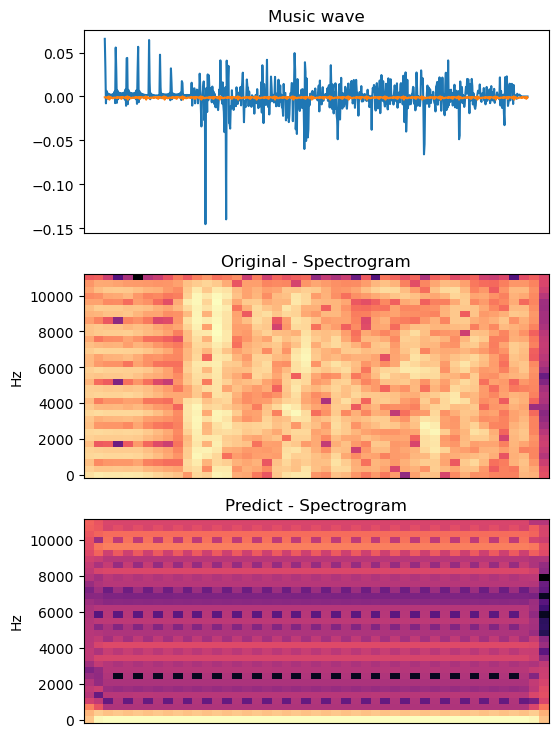

In [47]:
predict_sample();

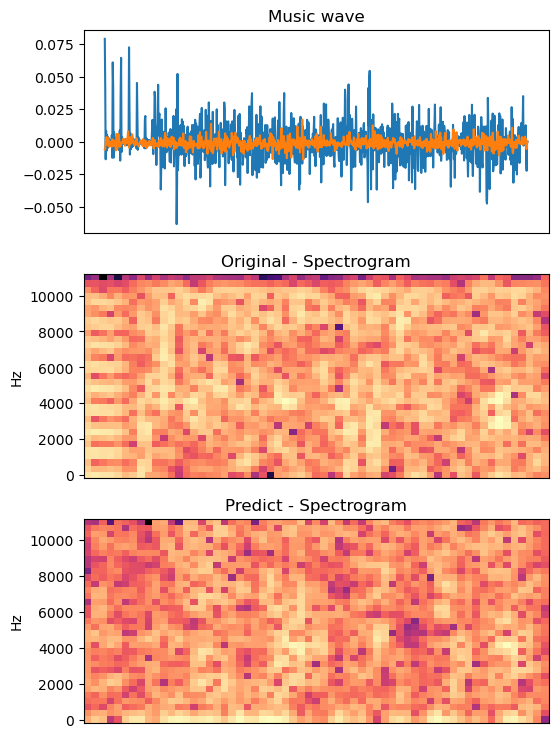

In [48]:
predict_sample();

### By Best Loss Model

In [49]:
net.load_state_dict(th.load(f'experiments/{trial_type}_{MODEL}/model-{MODEL_SIGNATURE}-best-loss-iter-{best_iter:03d}.pt'))

<All keys matched successfully>

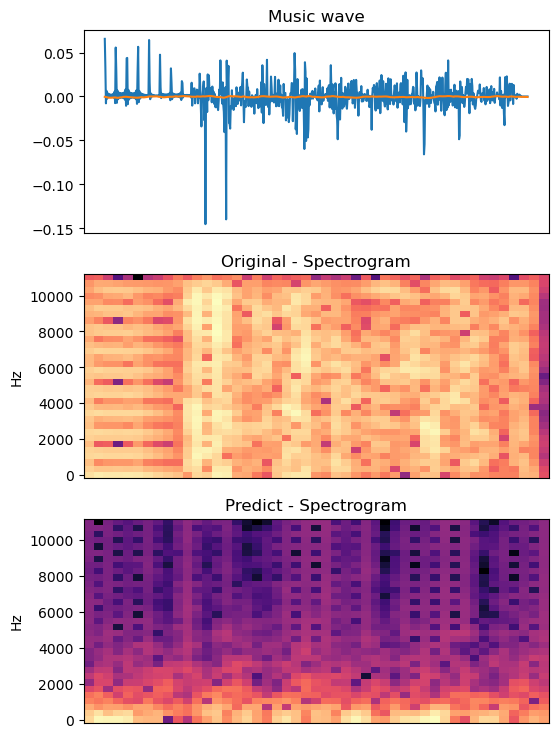

In [65]:
predict_sample();

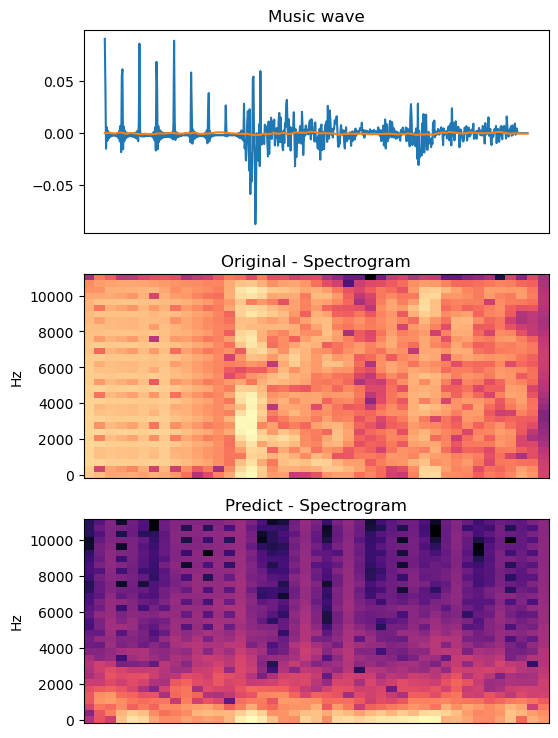

In [55]:
predict_sample();